# Why are delta-AUC-PR scores so different across datasets?
The output of the notebook 4.3 shows that there is vastly different performance for our pipeline depending upon which dataset is being used. Prism results in delta-AUC-PR scores that are marginally better than chance. However, the delta-AUC-PR scores are significantly better for toxvaldb (0.2-0.3). What is the reason for this vastly different performance aross support set sizes?

I will start by exploring some of the following questions:
- Are there some types of assays (e.g. aquatic predictions) for which toxvaldb has significantly better classification performance?
- Does the average assay across datasets have a similar active ratio?

In [108]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import duckdb

## Assay makeup

In [30]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.dataset" in part and "params.support_set_size" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    dataset = params[0].split("=")[1]
    support_set_size = int(params[1].split("=")[1])  # convert to int for numerical operations

    return {"dataset": dataset, "support_set_size": support_set_size}


def rename_filename_to_assay_id(filename):
    # Get basename without file extension from filename
    base_name = os.path.basename(filename)
    name_without_extension = os.path.splitext(base_name)[0]
    return name_without_extension

In [62]:
RUN_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-20/15-53-19"
run_dirs = [f"{RUN_DIR}/{config}" for config in os.listdir(RUN_DIR) if config != "multirun.yaml"]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

support_sizes = [8, 16, 32, 64]
datasets = ["toxcast", "toxval", "nci60", "cancerrx", "prism"]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr, filename AS assay_id
    FROM read_parquet('{run_dir}', filename=true)
    """
    try:
        df = con.execute(query).df()
        df["support_set_size"] = info["support_set_size"]
        df["dataset"] = info["dataset"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} with support set size of {info['support_set_size']}")


# Concatenate all dataframes into one
df = pd.concat(dfs, ignore_index=True)

# Change assay id column so that filename is converted to assay id
df["assay_id"] = df["assay_id"].apply(rename_filename_to_assay_id)

In [63]:
df.head()

,delta_auc_pr,assay_id,support_set_size,dataset
0,0.214189,dc81033bf0ce9cb,32,toxcast
1,0.078312,9d741d12f26e3a2,32,toxcast
2,0.207396,2da3a1f2bb38e61,32,toxcast
3,0.072056,663edce479311b3,32,toxcast
4,0.114713,0660b7e9e225700,32,toxcast


## Assay breakdown
I will now have a look to see what the breakdown is of the different assays, and see if there is any pattern as to why it is easier to classify some assays compared to others.

In [64]:
toxval = df[df["dataset"] == "toxval"]
toxval_32 = df[df["support_set_size"] == 32]

In [65]:
toxval_components = pd.read_parquet(f"{RUN_DIR}/params.dataset=toxval,params.support_set_size=32/data/processed/assay_id/toxval.parquet")

In [67]:
pd.set_option('display.max_colwidth', None)

toxval_merged = toxval.merge(toxval_components, on="assay_id")
toxval_merged.sort_values(by="delta_auc_pr", ascending=False)

,delta_auc_pr,assay_id,support_set_size,dataset,assay_name
6,0.310458,3750021a43179d9,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_EC50_Water Flea_aqueous_mg/m3_neurotoxicity_ECOTOX"
0,0.289894,9e409008c12c454,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_LC50_Sheepshead Minnow_aqueous_mg/m3_mortality_ECOTOX"
21,0.289754,fbf18f4352e1c05,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Bluegill_aqueous_mg/m3_mortality_ECOTOX"
9,0.281419,83f8eb37368cb38,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Water Flea_aqueous_mg/m3_neurotoxicity_ECOTOX"
18,0.265265,0384960b45bc7c3,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Rainbow Trout_aqueous_mg/m3_mortality_ECOTOX"
2,0.247231,9e409008c12c454,32,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_LC50_Sheepshead Minnow_aqueous_mg/m3_mortality_ECOTOX"
10,0.244229,83f8eb37368cb38,16,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Water Flea_aqueous_mg/m3_neurotoxicity_ECOTOX"
11,0.230764,83f8eb37368cb38,32,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Water Flea_aqueous_mg/m3_neurotoxicity_ECOTOX"
20,0.207688,0384960b45bc7c3,32,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Rainbow Trout_aqueous_mg/m3_mortality_ECOTOX"
19,0.207216,0384960b45bc7c3,16,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Rainbow Trout_aqueous_mg/m3_mortality_ECOTOX"


There doesn't appear to be an obvious pattern as to which assays have better predictions based upon the type of assay.

## Active ratio
Maybe there is a correlation between predictive performance and the active ratio of a given assay. I will use the run where a support set size of 32 is used so that I can appear a given set of assays without the assays being repeated.

In [101]:
run_dir = f"{RUN_DIR}/params.dataset=toxval,params.support_set_size=32/data/processed/assay/*parquet"

query = f"""
    SELECT ground_truth, filename AS assay_id
    FROM read_parquet('{run_dir}', filename=true)
    """
df = con.execute(query).df()

# Change assay id column so that filename is converted to assay id
df["assay_id"] = df["assay_id"].apply(rename_filename_to_assay_id)

In [102]:
proportion = df.groupby("assay_id")["ground_truth"].sum() / df.groupby("assay_id")["ground_truth"].count()

In [103]:
df = df.merge(proportion, on="assay_id")
df.rename(columns={"ground_truth_x": "ground_truth", "ground_truth_y": "active_ratio"}, inplace=True)

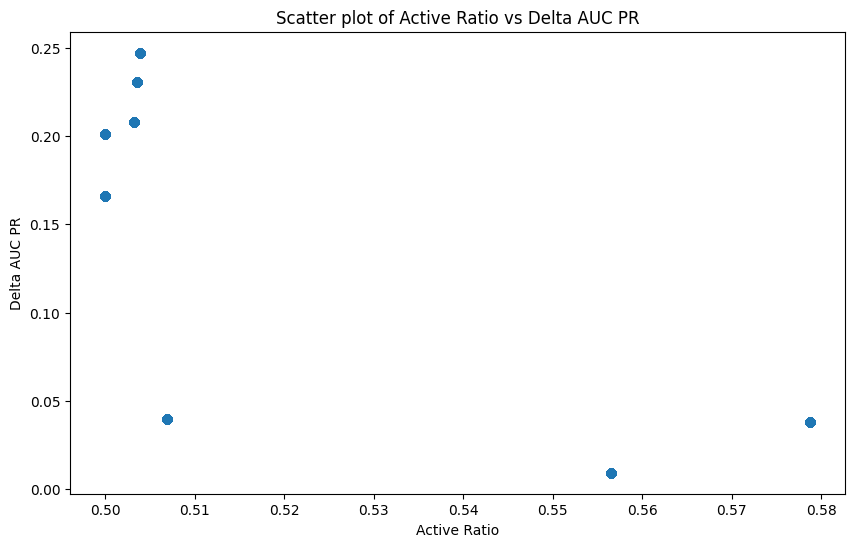

In [109]:
merged = toxval_32.merge(df, on="assay_id")

# Create scatter plot of merged["active_ratio"] vs merged["delta_auc_pr"]
plt.figure(figsize=(10, 6))
plt.scatter(merged["active_ratio"], merged["delta_auc_pr"])
plt.xlabel('Active Ratio')
plt.ylabel('Delta AUC PR')
plt.title('Scatter plot of Active Ratio vs Delta AUC PR')
plt.show()

It appears that those datapoints with an active ratio closer to 0.5 have better delta-AUC-PR scores. I want to check and see if this is the case for other dataset as well.

In [110]:
run_dir = f"{RUN_DIR}/params.dataset=toxcast,params.support_set_size=32/data/processed/assay/*parquet"

query = f"""
    SELECT ground_truth, filename AS assay_id
    FROM read_parquet('{run_dir}', filename=true)
    """
df = con.execute(query).df()

# Change assay id column so that filename is converted to assay id
df["assay_id"] = df["assay_id"].apply(rename_filename_to_assay_id)

In [111]:
proportion = df.groupby("assay_id")["ground_truth"].sum() / df.groupby("assay_id")["ground_truth"].count()

In [112]:
df = df.merge(proportion, on="assay_id")
df.rename(columns={"ground_truth_x": "ground_truth", "ground_truth_y": "active_ratio"}, inplace=True)

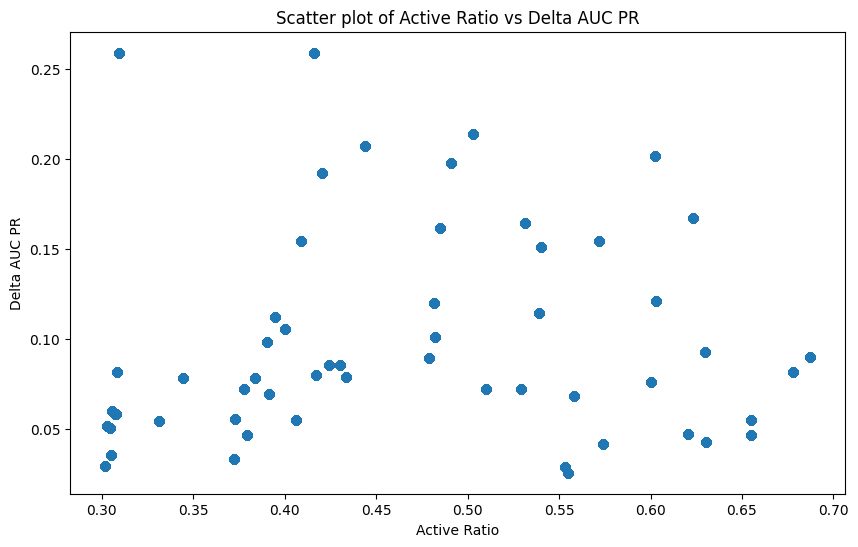

In [113]:
merged = toxval_32.merge(df, on="assay_id")

# Create scatter plot of merged["active_ratio"] vs merged["delta_auc_pr"]
plt.figure(figsize=(10, 6))
plt.scatter(merged["active_ratio"], merged["delta_auc_pr"])
plt.xlabel('Active Ratio')
plt.ylabel('Delta AUC PR')
plt.title('Scatter plot of Active Ratio vs Delta AUC PR')
plt.show()

This doesn't seem to hold true for other datasets.